In [180]:
import pandas as pd
import re
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import average_precision_score, precision_recall_curve, brier_score_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import shap

In [ ]:
df = pd.read_csv("/Users/jacobsussman/Desktop/subject_level_FC.csv")
#transfers = pd.read_csv("/Users/jacobsussman/Downloads/transfers.csv")
#radiology_notes = pd.read_csv("/Users/jacobsussman/Downloads/mimic-iv-note-deidentified-free-text-clinical-notes-2/note/radiology.csv.gz")

In [ ]:
patient_notes

In [ ]:
icu_units = [
    "Medical Intensive Care Unit (MICU)",
    "Surgical Intensive Care Unit (SICU)",
    "Medical/Surgical Intensive Care Unit (MICU/SICU)",
    "Cardiac Vascular Intensive Care Unit (CVICU)",
    "Neuro Surgical Intensive Care Unit (Neuro SICU)",
    "Trauma SICU (TSICU)",
    "Intensive Care Unit (ICU)"
]

icu_transfers = (
    transfers[transfers["careunit"].isin(icu_units)]
    .copy()
)

first_icu_time = (
    icu_transfers
    .sort_values("intime")
    .groupby("subject_id", as_index=False)
    .first()     # first row after sorting = earliest transfer
    [["subject_id", "intime"]]
)

first_icu_time = first_icu_time.rename(
    columns={"intime": "icu_transfer_time"}
)

df = df.merge(first_icu_time, on="subject_id", how="left")

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"\[\*\*.*?\*\*\]", " ", text)
    text = re.sub(r"[^a-zA-Z0-9.,;:()\-/% ]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip().lower()


radiology_notes["cleaned"] = radiology_notes["text"].apply(clean_text)

radiology_notes = radiology_notes.merge(
    df[["subject_id", "icu_transfer_time"]],
    on="subject_id",
    how="left"
)

radiology_notes["charttime"] = pd.to_datetime(radiology_notes["charttime"])
radiology_notes["icu_transfer_time"] = pd.to_datetime(radiology_notes["icu_transfer_time"])

filtered_notes = radiology_notes[
    (radiology_notes["icu_transfer_time"].notna()) &
    (radiology_notes["charttime"] <= radiology_notes["icu_transfer_time"] - pd.Timedelta(hours=4))
].copy()

patient_notes = (
    radiology_notes.groupby("subject_id")
    .apply(lambda g: " ".join(
        g.loc[
            (g["icu_transfer_time"].notna()) &
            (g["charttime"] <= g["icu_transfer_time"] - pd.Timedelta(hours=4)),
            "cleaned"
        ]
    ))
    .reset_index(name="cleaned_notes_4h_prior")
)


In [ ]:
transfers["careunit"].unique()

In [127]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


In [128]:
def embed_texts(text_list, batch_size=32, max_length=256):

    all_embeddings = []
    n = len(text_list)

    for i in tqdm(range(0, n, batch_size), desc="Embedding notes"):

        batch_texts = text_list[i:i+batch_size]

        # Fast batch tokenize
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**enc)

        # Mean pooling over tokens
        token_emb = outputs.last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1)
        pooled = (token_emb * mask).sum(1) / mask.sum(1)

        all_embeddings.append(pooled.cpu().numpy())

    return np.vstack(all_embeddings)


In [ ]:
embeddings = embed_texts(patient_notes["cleaned_notes_4h_prior"].tolist(), batch_size=64)

In [ ]:
emb_cols = [f"emb_{i}" for i in range(embeddings.shape[1])]
emb_df = pd.DataFrame(embeddings, columns=emb_cols)

patient_notes_emb = pd.concat([patient_notes["subject_id"], emb_df], axis=1)

In [ ]:
patient_notes_emb.to_csv("patient_note_embeddings.csv", index=False)

In [ ]:
full_df.head()

In [143]:
#df = pd.read_csv("/Users/jacobsussman/Desktop/subject_level_FC.csv")

full_df = df.merge(patient_notes_emb, on="subject_id", how="left")

full_df[emb_cols] = full_df[emb_cols].fillna(0)


y = full_df["ever_icu_any_visit"]

categorical = ["race", "gender"]
numeric = ["n_diagnoses", "anchor_age"] + emb_cols

ohe = OneHotEncoder(drop="first", sparse_output=False)
X_cat = ohe.fit_transform(full_df[categorical])
X_cat = pd.DataFrame(X_cat, columns=ohe.get_feature_names_out())

X_all = pd.concat([
    full_df[numeric].reset_index(drop=True),
    X_cat.reset_index(drop=True)
], axis=1)

In [144]:
X_all

,n_diagnoses,anchor_age,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,race_PORTUGUESE,race_SOUTH AMERICAN,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,gender_M
0,39,52,0.171130,-0.030298,-0.010640,-0.024046,-0.026444,-0.082116,-0.122401,0.107507,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,12,72,-0.756493,0.307456,-0.016221,-0.070094,0.330704,0.065515,0.734817,0.004461,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,22,48,-0.756493,0.307456,-0.016221,-0.070094,0.330704,0.065515,0.734817,0.004461,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2,60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,6,34,-0.756493,0.307456,-0.016221,-0.070094,0.330704,0.065515,0.734817,0.004461,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152948,11,35,-0.756493,0.307456,-0.016221,-0.070094,0.330704,0.065515,0.734817,0.004461,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
152949,29,81,0.067833,0.119082,0.050412,0.047334,0.089386,0.050274,-0.028075,0.100175,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
152950,3,19,-0.756493,0.307456,-0.016221,-0.070094,0.330704,0.065515,0.734817,0.004461,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
152951,275,57,-0.756493,0.307456,-0.016221,-0.070094,0.330704,0.065515,0.734817,0.004461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
model = XGBClassifier()

model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Prints evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUPRC:", average_precision_score(y_test, y_pred_proba))

In [ ]:
X_no_notes = X_all.filter(regex='^(?!emb).*')

X_no_notes

In [ ]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "n_estimators": [300, 600],
}

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",     # fast + recommended
    device="cuda"            # use GPU if available
)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,                      # number of random configs to test
    scoring="roc_auc",              # what to optimize
    cv=5,                           # 5-fold CV
    verbose=2,
    n_jobs=-1,
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best parameters:", search.best_params_)

In [ ]:
pred_proba = best_model.predict_proba(X_test)[:, 1]

results = {
    "AUROC": roc_auc_score(y_test, pred_proba),
    "AUPRC": average_precision_score(y_test, pred_proba),
    "Brier": brier_score_loss(y_test, pred_proba)
}

print(results)

In [ ]:
def cv_run(X):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        device="cuda"
    )

    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_grid,
        n_iter=5,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1
    )

    search.fit(X_train, y_train)

    y_hat = search.best_estimator_.predict_proba(X_test)[:,1]

    return {
        "model": search.best_estimator_,
        "params": search.best_params_,
        "auroc": roc_auc_score(y_test, y_hat),
        "auprc": average_precision_score(y_test, y_hat),
        "brier": brier_score_loss(y_test, y_hat)
    }


In [203]:
results_no_notes = cv_run(X_no_notes)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [204]:
results_no_notes

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9, device='cuda', early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.05, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=300, n_jobs=None,
               num_parallel_tree=None, ...),
 'params': {'subsample': 0.7,
  'n_estimators': 300,
  'max_depth': 3,
  'learning_rate': 0.05,
  'colsample_bytree': 0.9},
 'auroc': 0.8036178685628188,
 'auprc': 0.579219614867654,
 'brier': 0.148481

In [119]:
train_ids, test_ids = train_test_split(
    df["subject_id"].unique(),
    test_size=0.2,
    random_state=42,
    stratify=df["ever_icu_any_visit"]
)

df["subject_id"] = df["subject_id"].astype(int)
radiology_notes["subject_id"] = radiology_notes["subject_id"].astype(int)


df["subject_id"] = df["subject_id"].astype(int)
radiology_notes["subject_id"] = radiology_notes["subject_id"].astype(int)

train_df = df[df["subject_id"].isin(train_ids)].reset_index(drop=True)
test_df  = df[df["subject_id"].isin(test_ids)].reset_index(drop=True)

train_notes = radiology_notes[radiology_notes["subject_id"].isin(train_ids)].copy()
test_notes  = radiology_notes[radiology_notes["subject_id"].isin(test_ids)].copy()

train_notes["cleaned"] = train_notes["text"].apply(clean_text)
test_notes["cleaned"]  = test_notes["text"].apply(clean_text)

In [123]:
train_concat

,subject_id,cleaned
0,10000032,examination: chest (pa and lat) indication: wi...
1,10000980,history: screening. digital screening mammogra...
2,10001217,study: mri of the head with and without contra...
3,10001725,type of the exam: mr defecography. comparison ...
4,10001884,history: cough and shortness of breath with re...
...,...,...
22271,19998330,reason for the examination: woman with ckd and...
22272,19999287,"ap chest, 12:41 p.m. history: right vats. chec..."
22273,19999442,"indication: man with intractable epilepsy, lef..."
22274,19999625,indication: year old man with body disease s/p...


In [121]:
def keep_notes_before_icu(df_notes):
    df_notes["charttime"] = pd.to_datetime(df_notes["charttime"])
    df_notes["icu_transfer_time"] = pd.to_datetime(df_notes["icu_transfer_time"])
    return df_notes[df_notes["charttime"] <= df_notes["icu_transfer_time"] - pd.Timedelta(hours=4)]

train_notes = keep_notes_before_icu(train_notes)
test_notes  = keep_notes_before_icu(test_notes)

train_concat = (
    train_notes.groupby("subject_id")["cleaned"]
    .apply(lambda x: " ".join(x))
    .reset_index()
)

test_concat = (
    test_notes.groupby("subject_id")["cleaned"]
    .apply(lambda x: " ".join(x))
    .reset_index()
)

In [129]:
train_embeddings = embed_texts(train_concat["cleaned"].tolist(), batch_size=64)

Embedding notes: 100%|████████████████████████| 349/349 [12:54<00:00,  2.22s/it]


In [130]:
test_embeddings = embed_texts(test_concat["cleaned"].tolist(), batch_size=64)

Embedding notes: 100%|██████████████████████████| 88/88 [03:02<00:00,  2.07s/it]


In [131]:
emb_cols = [f"emb_{i}" for i in range(train_embeddings.shape[1])]

train_emb_df = pd.DataFrame(train_embeddings, columns=emb_cols)
train_emb_df["subject_id"] = train_concat["subject_id"].values

test_emb_df = pd.DataFrame(test_embeddings, columns=emb_cols)
test_emb_df["subject_id"] = test_concat["subject_id"].values

In [191]:
train_df = df[df["subject_id"].isin(train_ids)].copy()
test_df  = df[df["subject_id"].isin(test_ids)].copy()

train_final = train_df.merge(train_emb_df, on="subject_id", how="left")
test_final  = test_df.merge(test_emb_df,  on="subject_id", how="left")

categorical_cols = ["race", "gender"]
numeric_cols = ["anchor_age", "BMI", "n_hadm"]
embedding_cols = [c for c in train_final.columns if c.startswith("emb_")]

y_train = train_final["ever_icu_any_visit"]
y_test  = test_final["ever_icu_any_visit"]

ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)

# Fit only on the training set
ohe.fit(train_final[categorical_cols])

# Transform both
X_train_cat = pd.DataFrame(
    ohe.transform(train_final[categorical_cols]),
    columns=ohe.get_feature_names_out(categorical_cols),
    index=train_final.index
)

X_test_cat = pd.DataFrame(
    ohe.transform(test_final[categorical_cols]),
    columns=ohe.get_feature_names_out(categorical_cols),
    index=test_final.index
)

X_train_num = train_final[numeric_cols]
X_test_num  = test_final[numeric_cols]

X_train_emb = train_final[embedding_cols]
X_test_emb  = test_final[embedding_cols]

X_train = pd.concat([X_train_num, X_train_cat, X_train_emb], axis=1)
X_test  = pd.concat([X_test_num,  X_test_cat,  X_test_emb],  axis=1)

In [236]:
xgb = XGBClassifier()

xgb.fit(X_train_reduced, y_train)

type(y_train)

pandas.core.series.Series

In [233]:
y_pred = xgb.predict(X_test_reduced)
y_pred_proba = xgb.predict_proba(X_test_reduced)[:, 1]

# Prints evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUPRC:", average_precision_score(y_test, y_pred_proba))

ValueError: feature_names mismatch: ['anchor_age', 'n_diagnoses', 'race_ASIAN', 'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE', 'race_ASIAN - KOREAN', 'race_ASIAN - SOUTH EAST ASIAN', 'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN', 'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND', 'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - CENTRAL AMERICAN', 'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - CUBAN', 'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - GUATEMALAN', 'race_HISPANIC/LATINO - HONDURAN', 'race_HISPANIC/LATINO - MEXICAN', 'race_HISPANIC/LATINO - PUERTO RICAN', 'race_HISPANIC/LATINO - SALVADORAN', 'race_MULTIPLE RACE/ETHNICITY', 'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_OTHER', 'race_PATIENT DECLINED TO ANSWER', 'race_PORTUGUESE', 'race_SOUTH AMERICAN', 'race_UNABLE TO OBTAIN', 'race_UNKNOWN', 'race_WHITE', 'race_WHITE - BRAZILIAN', 'race_WHITE - EASTERN EUROPEAN', 'race_WHITE - OTHER EUROPEAN', 'race_WHITE - RUSSIAN', 'gender_M', 'pca_emb_0', 'pca_emb_1', 'pca_emb_2', 'pca_emb_3', 'pca_emb_4', 'pca_emb_5', 'pca_emb_6', 'pca_emb_7', 'pca_emb_8', 'pca_emb_9'] ['anchor_age', 'BMI', 'n_hadm', 'race_ASIAN', 'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE', 'race_ASIAN - KOREAN', 'race_ASIAN - SOUTH EAST ASIAN', 'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN', 'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND', 'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - CENTRAL AMERICAN', 'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - CUBAN', 'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - GUATEMALAN', 'race_HISPANIC/LATINO - HONDURAN', 'race_HISPANIC/LATINO - MEXICAN', 'race_HISPANIC/LATINO - PUERTO RICAN', 'race_HISPANIC/LATINO - SALVADORAN', 'race_MULTIPLE RACE/ETHNICITY', 'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_OTHER', 'race_PATIENT DECLINED TO ANSWER', 'race_PORTUGUESE', 'race_SOUTH AMERICAN', 'race_UNABLE TO OBTAIN', 'race_UNKNOWN', 'race_WHITE', 'race_WHITE - BRAZILIAN', 'race_WHITE - EASTERN EUROPEAN', 'race_WHITE - OTHER EUROPEAN', 'race_WHITE - RUSSIAN', 'gender_M', 'pca_emb_0', 'pca_emb_1', 'pca_emb_2', 'pca_emb_3', 'pca_emb_4', 'pca_emb_5', 'pca_emb_6', 'pca_emb_7', 'pca_emb_8', 'pca_emb_9']
expected n_diagnoses in input data
training data did not have the following fields: n_hadm, BMI

In [215]:
embedding_cols = [c for c in X_train.columns if c.startswith("emb_")]

X_train[embedding_cols] = X_train[embedding_cols].fillna(0)
X_test[embedding_cols]  = X_test[embedding_cols].fillna(0)

train_emb = X_train[embedding_cols].values
test_emb  = X_test[embedding_cols].values

pca = PCA(n_components=10, random_state=42)

pca.fit(train_emb)

train_emb_pca = pca.transform(train_emb)
test_emb_pca  = pca.transform(test_emb)

pca_cols = [f"pca_emb_{i}" for i in range(train_emb_pca.shape[1])]

train_pca_df = pd.DataFrame(train_emb_pca, columns=pca_cols, index=X_train.index)
test_pca_df  = pd.DataFrame(test_emb_pca,  columns=pca_cols, index=X_test.index)

X_train_reduced = X_train.drop(columns=embedding_cols)
X_test_reduced  = X_test.drop(columns=embedding_cols)

# Add PCA components
X_train_reduced = pd.concat([X_train_reduced, train_pca_df], axis=1)
X_test_reduced  = pd.concat([X_test_reduced,  test_pca_df],  axis=1)

In [216]:
pca_cols = [c for c in X_train_reduced.columns if c.startswith("pca_emb_")]

# WITH embeddings
X_train_with = X_train_reduced.copy()
X_test_with  = X_test_reduced.copy()

# WITHOUT embeddings
X_train_without = X_train_reduced.drop(columns=pca_cols)
X_test_without  = X_test_reduced.drop(columns=pca_cols)


def cv_eval(X, y, params, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs, briers = [], []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBClassifier(**params)
        model.fit(X_tr, y_tr)

        preds = model.predict_proba(X_val)[:, 1]

        aucs.append(roc_auc_score(y_val, preds))
        briers.append(brier_score_loss(y_val, preds))

    return np.mean(aucs), np.mean(briers)

params = dict(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.9,
    eval_metric="logloss"
)

auc_with,   brier_with   = cv_eval(X_train_with, y_train, params)
auc_without, brier_without = cv_eval(X_train_without, y_train, params)

print("=== CV RESULTS ===")
print(f"With embeddings:    AUC={auc_with:.3f}, Brier={brier_with:.3f}")
print(f"Without embeddings: AUC={auc_without:.3f}, Brier={brier_without:.3f}")

=== CV RESULTS ===
With embeddings:    AUC=0.920, Brier=0.064
Without embeddings: AUC=0.751, Brier=0.162


In [217]:
def fit_and_predict(X_train, y_train, X_test):
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    return model, preds


model_with, preds_with       = fit_and_predict(X_train_with, y_train, X_test_with)
model_without, preds_without = fit_and_predict(X_train_without, y_train, X_test_without)


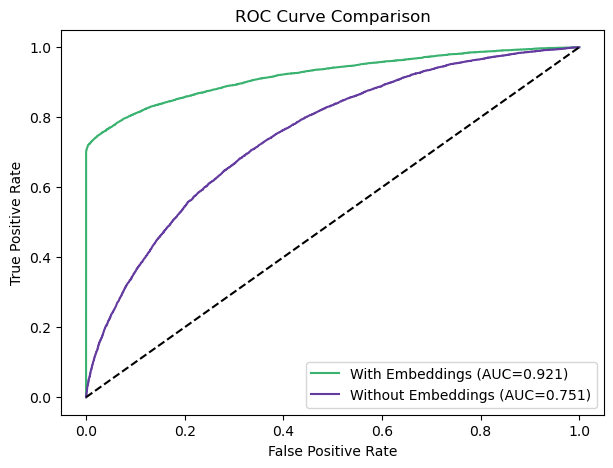

In [221]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7,5))

# With embeddings
fpr_w, tpr_w, _ = roc_curve(y_test, preds_with)
auc_w = auc(fpr_w, tpr_w)

# Without embeddings
fpr_wo, tpr_wo, _ = roc_curve(y_test, preds_without)
auc_wo = auc(fpr_wo, tpr_wo)

plt.plot(fpr_w, tpr_w, color="#3ab270", label=f"With Embeddings (AUC={auc_w:.3f})")
plt.plot(fpr_wo, tpr_wo, color="#643b9f", label=f"Without Embeddings (AUC={auc_wo:.3f})")
plt.plot([0,1], [0,1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()



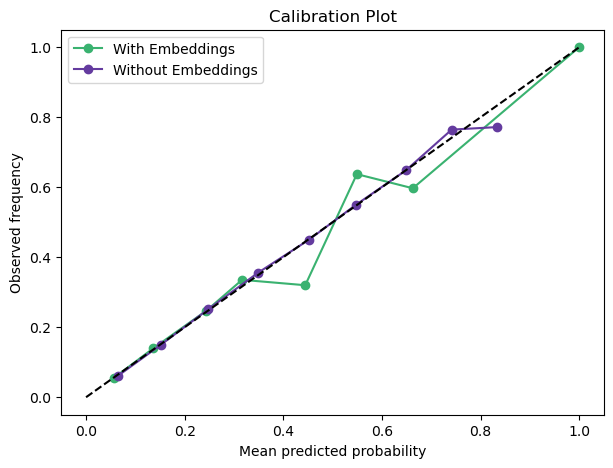

In [222]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(7,5))

# Specify colors for each curve
colors = {"With Embeddings": "#3ab270", "Without Embeddings": "#643b9f"}

for preds, name in [(preds_with,"With Embeddings"), (preds_without,"Without Embeddings")]:
    prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', color=colors[name], label=name)

plt.plot([0,1],[0,1],'k--')  # perfect calibration line
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Plot")
plt.legend()
plt.show()


In [197]:
explainer_with = shap.TreeExplainer(model_with)
explainer_no   = shap.TreeExplainer(model_without)

In [225]:
shap_vals_with = explainer_with.shap_values(X_train_with)
shap_vals_no   = explainer_no.shap_values(X_train_without)

XGBoostError: [16:46:14] /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/c_api/c_api_utils.h:129: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (5751014 vs. 10645494) : 
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000005a43761ec dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000005a4404b84 xgboost::CalcPredictShape(bool, xgboost::PredictionType, unsigned long, unsigned long, unsigned long, unsigned long, unsigned long, std::__1::vector<unsigned long long, std::__1::allocator<unsigned long long>>*, unsigned long long*) + 1216
  [bt] (2) 3   libxgboost.dylib                    0x00000005a4403f24 XGBoosterPredictFromDMatrix + 1260
  [bt] (3) 4   libffi.8.dylib                      0x0000000103be804c ffi_call_SYSV + 76
  [bt] (4) 5   libffi.8.dylib                      0x0000000103be5834 ffi_call_int + 1404
  [bt] (5) 6   _ctypes.cpython-312-darwin.so       0x0000000103d5c284 _ctypes_callproc + 1044
  [bt] (6) 7   _ctypes.cpython-312-darwin.so       0x0000000103d56404 PyCFuncPtr_call + 212
  [bt] (7) 8   python3.12                          0x0000000100ed4c6c _PyEval_EvalFrameDefault + 221940
  [bt] (8) 9   python3.12                          0x0000000100e9c544 PyEval_EvalCode + 236



In [224]:
shap.summary_plot(shap_vals_with, X_train_with)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [1]:
shap.summary_plot(shap_vals_no, X_train_without, plot_type="bar")

NameError: name 'shap' is not defined

In [209]:
loadings = pd.DataFrame(
    pca.components_,
    columns=embedding_cols,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
loadings.head()  # first 5 PCs

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
PC1,0.077401,0.025302,-0.008948,-0.018302,-0.017039,-0.068310,-0.102870,0.100959,0.031650,-0.029874,...,-0.056947,0.060227,0.046349,0.044562,-0.011489,0.077420,0.039435,-0.011730,0.002093,0.015569
PC2,0.052790,0.128984,0.005105,0.041254,0.083657,0.062649,-0.018548,-0.054521,0.001137,0.004535,...,-0.031088,0.100746,-0.081799,-0.001917,0.001475,-0.039465,0.027099,-0.071880,-0.032545,0.092460
PC3,-0.085349,0.048204,-0.022065,0.010069,-0.006196,0.051160,-0.108983,0.012530,0.027666,-0.023459,...,-0.029273,-0.027842,-0.060004,0.046963,-0.009361,-0.048379,-0.010627,0.052506,0.040570,0.002307
PC4,0.074258,-0.004738,-0.035863,-0.000814,-0.043333,-0.015619,0.002917,-0.024089,-0.015925,-0.132944,...,0.096739,-0.067975,0.013754,-0.028762,-0.031350,-0.029907,0.038070,0.101724,0.070453,-0.036016
PC5,-0.054412,0.009081,0.012557,0.047426,0.013164,-0.000362,-0.007766,0.058574,-0.024611,-0.021618,...,-0.026920,0.042681,-0.121738,-0.006066,0.019685,0.057138,0.039199,0.024231,-0.006016,0.071616


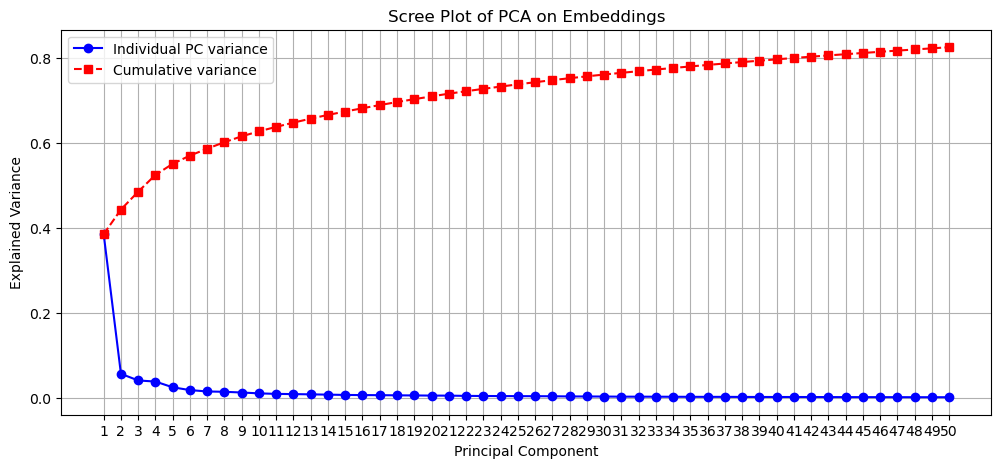

In [214]:
explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(12,5))
plt.plot(range(1, len(explained_var)+1), explained_var, 'o-', color='blue', label='Individual PC variance')
plt.plot(range(1, len(explained_var)+1), np.cumsum(explained_var), 's--', color='red', label='Cumulative variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Scree Plot of PCA on Embeddings')
plt.xticks(range(1, len(explained_var)+1))
plt.grid(True)
plt.legend()
plt.show()

In [231]:
train_emb_df.to_csv("train_embeddings.csv", index = False)

In [232]:
test_emb_df.to_csv("test_embeddings.csv", index = False)